In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

In [ ]:
# --- 1. define the U-Net architecture  ---
# U-Net is the backbone of diffusion models as it excels in image-to-image tasks and skip connections help retain details.

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t):
        h = self.bn1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bn2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [ ]:
# --- 2. helping functions for the diffusion process  ---

# hyperparameters for the diffusion process
T = 300 # total diffusion steps
betas = torch.linspace(1e-4, 0.02, T) # Beta schedule
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_index_from_list(vals, t, x_shape):
    # return a specific index t of a passed list of values vals, then reshape to [batch_size, 1, 1, 1, ...] for broadcasting purposes
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    # forward diffusion (adding noise) step: adds noise to x_0 at step t
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    mean = sqrt_alphas_cumprod_t * x_0
    variance = sqrt_one_minus_alphas_cumprod_t * noise
    return mean + variance, noise

@torch.no_grad()
def sample_timestep(x, t, model):
    # reverse diffusion (removing noise) step: predicts the noise in x_t
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t.all() == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(model, device, img_size):
    # plotting the diffusion process
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(15,3))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, model)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            plt.imshow(img.cpu().squeeze().numpy(), cmap="gray")
            plt.title(f"t={i}")
    plt.show()

Using device: cuda


Epoch 1/20:   0%|          | 1/468 [00:03<26:23,  3.39s/it]

 Loss: 1.029367446899414


Epoch 1/20:  43%|████▎     | 201/468 [19:18<1:13:36, 16.54s/it]

 Loss: 0.040489014238119125


Epoch 1/20:  86%|████████▌ | 402/468 [50:53<12:10, 11.06s/it]  

 Loss: 0.024737689644098282


Epoch 1/20: 100%|██████████| 468/468 [59:34<00:00,  7.64s/it]


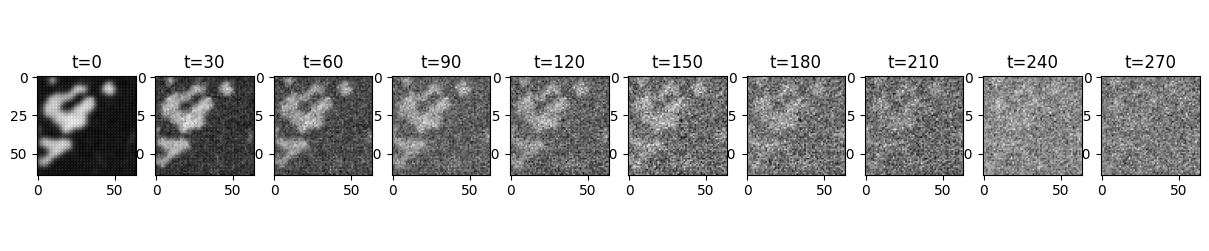

Epoch 2/20:   0%|          | 1/468 [00:06<47:41,  6.13s/it]

 Loss: 0.027947358787059784


Epoch 2/20:   1%|          | 5/468 [00:30<46:36,  6.04s/it]


KeyboardInterrupt: 

In [ ]:
# --- 3. training the model ---

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
IMG_SIZE = 64
BATCH_SIZE = 128
epochs = 20 

# load dataset and prepare dataloader
transforms = Compose([
    Resize(IMG_SIZE),
    CenterCrop(IMG_SIZE),
    ToTensor(), # Turn image into torch.Tensor values between 0 & 1
    Lambda(lambda t: (t * 2) - 1) # Scale to [-1, 1]
])
dataset = torchvision.datasets.MNIST(root="data/", train=True, transform=transforms, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# initialize model, optimizer, and loss function
model = SimpleUnet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

#  training loop    
for epoch in range(epochs):
    for step, (images, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
        optimizer.zero_grad()
        
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        x_noisy, noise = forward_diffusion_sample(images.to(device), t, device)
        predicted_noise = model(x_noisy, t)
        
        loss = loss_fn(noise, predicted_noise)
        loss.backward()
        optimizer.step()

        if step % 200 == 0:
            print(f" Loss: {loss.item()}")

    #every epoch, plot the diffusion process
    sample_plot_image(model, device, IMG_SIZE)